# Clonar archivos y modelos

In [ ]:
!git clone https://github.com/WUT-IDEA/MealRecPlus.git

Cloning into 'MealRecPlus'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 132 (delta 49), reused 94 (delta 26), pack-reused 0 (from 0)
Receiving objects: 100% (132/132), 2.02 MiB | 11.25 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Filtering content: 100% (4/4), 382.41 MiB | 24.58 MiB/s, done.


In [ ]:
%cd MealRecPlus/MealRec+

/content/MealRecPlus/MealRec+


In [ ]:
!ls

data_load.py  MealRec+H  MealRec+L


In [ ]:
!pip install git+https://github.com/daviddavo/lightfm

  Cloning https://github.com/daviddavo/lightfm to /tmp/pip-req-build-qvb1st2r
  Running command git clone --filter=blob:none --quiet https://github.com/daviddavo/lightfm /tmp/pip-req-build-qvb1st2r
  Resolved https://github.com/daviddavo/lightfm to commit f0eb500ead54ab65eb8e1b3890337a7223a35114
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp312-cp312-linux_x86_64.whl size=1099141 sha256=1546f53da48e9594a7bfedbc87b365f5614057f56d003abc0f6bdb704991fd28
  Stored in directory: /tmp/pip-ephem-wheel-cache-fkwpkcoq/wheels/fd/89/93/70c1e5f378ee5043de89387ee3ef6852ff39e3b9eb44ecc1a3
Successfully built lightfm


In [ ]:
!pip install recommenders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.3/355.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.6/29.6 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.1/538.1 kB 29.6 MB/s et

# Preparación del entorno

In [ ]:
import os
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

# LightFm
from lightfm import LightFM
from lightfm.data import Dataset

# LightGCN
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
from data_load import get_dataset

train, test, course, aff, cat = get_dataset(".","MealRec+H")

>>>>>>>>>>M-S statistics>>>>>>>>>>
Average interactions 3.0
Non-zero rows 1.0
Non-zero columns 0.1293956043956044
Matrix density 0.0004120879120879121
finish loading affiliation data
>>>>>>>>>>S-C statistics>>>>>>>>>>
Average interactions 1.5729395151138306
Non-zero rows 0.1293956043956044
Non-zero columns 1.0
Matrix density 0.04313186813186813
finish loading course data
>>>>>>>>>>U-S statistics>>>>>>>>>>
Average interactions 95.96698760986328
Non-zero rows 1.0
Non-zero columns 1.0
Matrix density 0.013182278039420896
finish loading course data
>>>>>>>>>>U-M statistics in train>>>>>>>>>>
Average interactions 23.75428581237793
Non-zero rows 1.0
Non-zero columns 0.9981660990306523
Matrix density 0.006223286799655676
finish loading meal train data
>>>>>>>>>>U-M statistics in test>>>>>>>>>>
Average interactions 2.9695239067077637
Non-zero rows 0.7180952380952381
Non-zero columns 0.6109510086455331
Matrix density 0.0007779732275409509
finish loading meal test data
>>>>>>>>>>M-S statistics>>>

In [ ]:
print("Train size:", len(train))
print("Test size:", len(test))
print("Ejemplo de item train:", train[100])
print("Ejemplo de item test:", test[20])

Train size: 37413
Test size: 1575
Ejemplo de item train: (tensor([1350]), tensor([ 179, 1171]))
Ejemplo de item test: (20, tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]))


Datos de salud:

In [ ]:
# 1: WHO meal scores
def load_meal_who_scores(base_path=".", dataset_name="MealRec+H"):
    """
    Devuelve np.array de tamaño num_meals con el score WHO para cada meal (float).
    """

    file_path = os.path.join(base_path, dataset_name, "healthiness", "meal_who.txt")

    if file_path is None:
        raise FileNotFoundError("No se encontró meal_who.txt")

    scores = []
    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if line == "":
                scores.append(np.nan)
            else:
                # el loader original parsea por tabs; aquí puede venir 1 valor por línea
                parts = line.split('\t')
                # toma el primero por si acaso
                scores.append(float(parts[0]))
    return np.array(scores, dtype=float)

# load
meal_who_raw = load_meal_who_scores(base_path=".", dataset_name="MealRec+H")


In [ ]:
# 2: FSA meal scores:
def load_meal_fsa_scores(base_path=".", dataset_name="MealRec+H"):
    """
    Devuelve np.array(num_meals,) con el puntaje FSA por meal.
    """

    file_path = os.path.join(base_path, dataset_name, "healthiness", "meal_fsa.txt")

    if file_path is None:
        raise FileNotFoundError("No se encontró meal_fsa.txt")

    vals = []
    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if line == "":
                vals.append(np.nan)
            else:
              parts = line.split('\t')
              vals.append(float(parts[0]))
    return np.array(vals, dtype=float)

# load
meal_fsa_raw = load_meal_fsa_scores(base_path=".", dataset_name="MealRec+H")


# Baselines

In [ ]:
train_pairs = train.U_M_pairs
test_pairs = test.U_M_pairs
num_users, num_meals = train.num_users, train.num_meals

RANDOM

In [ ]:
import numpy as np

def recommend_random(user_id, top_n=10):
    return np.random.choice(num_meals, size=top_n, replace=False)

MOST POPULAR

In [ ]:
from collections import Counter

meal_counts = Counter([meal for (u, meal) in train_pairs])
most_popular = [m for m, _ in meal_counts.most_common()]

def recommend_most_popular(user_id, top_n=10):
    return most_popular[:top_n]

POPULAR CATEGORIES

In [ ]:
from collections import defaultdict, Counter

meal_to_courses = defaultdict(list)
for (m, s) in aff.M_S_pairs:
    meal_to_courses[m].append(s)

course_to_cat = {}
for (s, c) in cat.S_C_pairs:
    course_to_cat[s] = c

meal_to_cat = {}
for m, courses in meal_to_courses.items():
    cats = [course_to_cat[s] for s in courses if s in course_to_cat]
    if cats:
        meal_to_cat[m] = Counter(cats).most_common(1)[0][0]

In [ ]:
user_meals = defaultdict(list)
for u, m in train_pairs:
    user_meals[u].append(m)

user_dom_cat = {}
for u, meals in user_meals.items():
    cats = [meal_to_cat[m] for m in meals if m in meal_to_cat]
    if cats:
        user_dom_cat[u] = Counter(cats).most_common(1)[0][0]
    else:
        user_dom_cat[u] = None

In [ ]:
pop_by_cat = {0: Counter(), 1: Counter(), 2: Counter()}
for _, m in train_pairs:
    c = meal_to_cat.get(m)
    if c is not None:
        pop_by_cat[c][m] += 1

poplist_by_cat = {c: [m for m, _ in cnt.most_common()] for c, cnt in pop_by_cat.items()}

In [ ]:
def recommend_hybrid_category(user_id, top_n=10, alpha=0.7):
    seen = set(user_meals[user_id])  # meals ya consumidos
    dom_cat = user_dom_cat.get(user_id)

    score = {}
    if dom_cat is not None:
        for rank, m in enumerate(poplist_by_cat[dom_cat][:5000], start=1):
            if m not in seen:
                score[m] = score.get(m, 0.0) + (1 - alpha) * (1.0 / rank)
    for rank, m in enumerate(most_popular[:5000], start=1):
        if m not in seen:
            score[m] = score.get(m, 0.0) + alpha * (1.0 / rank)
    recs = sorted(score.items(), key=lambda x: x[1], reverse=True)
    return [m for (m, _) in recs[:top_n]]

USER KNN

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix

# pares (usuario, meal) del train
train_pairs = train.U_M_pairs
num_users, num_meals = train.num_users, train.num_meals

# construir matriz dispersa (users x meals)
rows = [u for (u, m) in train_pairs]
cols = [m for (u, m) in train_pairs]
data = np.ones(len(train_pairs))
user_item_matrix = csr_matrix((data, (rows, cols)), shape=(num_users, num_meals))

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# matriz de similitud entre usuarios
user_sim = cosine_similarity(user_item_matrix)

In [ ]:
def recommend_userknn(user_id, top_n=10, k_neighbors=20):
    # similitud de este usuario con todos
    sims = user_sim[user_id]

    # ignorar self
    sims[user_id] = 0

    # top-k vecinos
    neighbors = sims.argsort()[::-1][:k_neighbors]

    # ítems que ya consumió este usuario
    seen = set(cols for (u, cols) in train_pairs if u == user_id)

    # acumular puntajes de recomendación por similitud
    scores = np.zeros(num_meals)
    for n in neighbors:
        neighbor_items = user_item_matrix[n].indices  # ítems que consumió el vecino
        for item in neighbor_items:
            if item not in seen:
                scores[item] += sims[n]  # sumar similitud como peso

    # top-n ítems recomendados
    recommended = scores.argsort()[::-1][:top_n]
    return recommended

EVALUATE BASELINES

In [ ]:
from collections import defaultdict

user_meals = defaultdict(list)
for u, m in train_pairs:
    user_meals[u].append(m)

def recommend_user_popular(user_id, top_n=10):
    counts = Counter(user_meals[user_id])
    ranked = [m for m, _ in counts.most_common()]
    return ranked[:top_n] if ranked else recommend_most_popular(user_id, top_n)

In [ ]:
def recall_at_k(recommended, relevant, k):
    if not relevant:
        return 0.0
    return len(set(recommended[:k]) & set(relevant)) / len(relevant)

def evaluate_baseline(recommender, k=10):
    total, n_users = 0, 0
    for u in range(num_users):
        relevant = [m for (uu, m) in test_pairs if uu == u]
        if not relevant:
            continue
        recs = recommender(u, top_n=k)
        total += recall_at_k(recs, relevant, k)
        n_users += 1
    return total / n_users

In [ ]:
print("Random Recall@10:", evaluate_baseline(recommend_random, k=10))
print("Most Popular Recall@10:", evaluate_baseline(recommend_most_popular, k=10))
print("Hybrid Category Recall@10:", evaluate_baseline(
    lambda u, top_n=10: recommend_hybrid_category(u, top_n=top_n, alpha=0.7),
    k=10
))
print("UserKNN Recall@10:", evaluate_baseline(
    lambda u, top_n=10: recommend_userknn(u, top_n=top_n, k_neighbors=20),
    k=10
))

Random Recall@10: 0.002430982786028616
Most Popular Recall@10: 0.024882846882535888
Hybrid Category Recall@10: 0.025863197010240476
UserKNN Recall@10: 0.10485435911719135


In [ ]:
# NDCG
def dcg_at_k(recommended, relevant_set, k):
    dcg = 0.0
    for i, m in enumerate(recommended[:k], start=1):
        if m in relevant_set:
            dcg += 1.0 / np.log2(i + 1)
    return dcg

def ndcg_at_k(recommended, relevant, k):
    if not relevant:
        return 0.0
    rel_set = set(relevant)
    dcg = dcg_at_k(recommended, rel_set, k)
    ideal_hits = min(len(rel_set), k)
    idcg = sum(1.0 / np.log2(i + 1) for i in range(1, ideal_hits + 1))
    return dcg / idcg if idcg > 0 else 0.0

def evaluate_ndcg_baseline(recommender, k=10):
    total, n_users = 0, 0
    for u in range(num_users):
        relevant = [m for (uu, m) in test_pairs if uu == u]
        if not relevant:
            continue
        recs = recommender(u, top_n=k)
        total += ndcg_at_k(recs, relevant, k)
        n_users += 1
    return total / n_users

In [ ]:
print("Random NDCG@10:", evaluate_ndcg_baseline(recommend_random, k=10))
print("Most Popular NDCG@10:", evaluate_ndcg_baseline(recommend_most_popular, k=10))
print("Hybrid Category NDCG@10:", evaluate_ndcg_baseline(
    lambda u, top_n=10: recommend_hybrid_category(u, top_n=top_n, alpha=0.7),
    k=10
))
print("UserKNN NDCG@10:", evaluate_ndcg_baseline(
    lambda u, top_n=10: recommend_userknn(u, top_n=top_n, k_neighbors=20),
    k=10
))

Random NDCG@10: 0.0024985055203336623
Most Popular NDCG@10: 0.016378488242446927
Hybrid Category NDCG@10: 0.018701485815558277
UserKNN NDCG@10: 0.07823331502394042


# Definición de metricas de salud

In [ ]:

# Normalizar health scores
def normalize_health_scores(raw_scores, invert_lower_is_healthier=True):
    """
    Devuelve scores_normalized en [0,1].
    Si invert_lower_is_healthier=True: menor raw -> más saludable -> valor normalizado más alto.
      norm = 1 - (x - min)/(max-min)
    Caso contrario:
      norm = (x - min)/(max-min)
    Si max==min, devuelve todo 1.0 para evitar NaN.
    """
    scores = raw_scores.copy().astype(float)
    # Manejo de NaN: si hay ausentes, los imputamos con la mediana
    if np.any(np.isnan(scores)):
        median = np.nanmedian(scores)
        scores = np.where(np.isnan(scores), median, scores)

    xmin, xmax = scores.min(), scores.max()
    if np.isclose(xmax - xmin, 0.0):
        norm = np.ones_like(scores, dtype=float)
    else:
        base = (scores - xmin) / (xmax - xmin)
        norm = 1.0 - base if invert_lower_is_healthier else base
    return norm

# Meals vistos por usuario
user_seen_meals = defaultdict(set)
for u, m in train_pairs:
    user_seen_meals[u].add(m)

# Metrica WHO_health@k
def whoHealth_at_k(recommender, k=10, exclude_seen=True):
    """
    Calcula el promedio macro de salud WHO normalizado en el top-k recomendado por usuario.
    - recommender: función user_id -> lista/array de ids de meals
    - k: cut-off
    - exclude_seen: si True, filtra meals ya consumidos en train antes de evaluar la salud
    """
    total, n_users = 0.0, 0
    for u in range(num_users):
        # recomendaciones
        recs = list(recommender(u, top_n=k))
        if exclude_seen:
            recs = [m for m in recs if m not in user_seen_meals[u]]
        if not recs:
            continue
        recs = recs[:k]

        # promedio de salud WHO normalizada en el top-k
        health_vals = [meal_who_norm[m] for m in recs]
        total += float(np.mean(health_vals))
        n_users += 1

    return total / n_users if n_users > 0 else 0.0

# Metrica FSA_health@k
def fsaHealth_at_k(recommender, k=10, exclude_seen=True):
    """
    Promedio macro del score FSA normalizado en el top-k recomendado por usuario.
    """
    total, n_users = 0.0, 0
    for u in range(num_users):
        recs = list(recommender(u, top_n=k))
        if exclude_seen:
            recs = [m for m in recs if m not in user_seen_meals[u]]
        if not recs:
            continue
        recs = recs[:k]

        health_vals = [meal_fsa_norm[m] for m in recs]
        total += float(np.mean(health_vals))
        n_users += 1

    return total / n_users if n_users > 0 else 0.0



In [ ]:
# Función para evaluar todas las metricas
def evaluate_recommender_metrics(recommender, k=10):
    """Evalúa Recall@k, NDCG@k, WHO_health@k y FSA_health@k"""
    recall = evaluate_baseline(recommender, k=k)

    # NDCG@k
    total_ndcg, n_users = 0.0, 0
    user_test = defaultdict(list)
    for (u, m) in test_pairs:
        user_test[u].append(m)
    for u in range(num_users):
        relevant = user_test[u]
        if not relevant:
            continue
        recs = recommender(u, top_n=k)
        total_ndcg += ndcg_at_k(recs, relevant, k)
        n_users += 1
    ndcg = total_ndcg / n_users if n_users > 0 else 0.0

    # WHO y FSA
    whoH = whoHealth_at_k(recommender, k=k)
    fsaH = fsaHealth_at_k(recommender, k=k)

    return recall, ndcg, whoH, fsaH

Normalizar who y fsa scores:

In [ ]:
meal_who_norm = normalize_health_scores(meal_who_raw, invert_lower_is_healthier=False)
meal_fsa_norm = normalize_health_scores(meal_fsa_raw, invert_lower_is_healthier=True)

Evaluar recomendadores con nuevas metricas

In [ ]:
# whoHealt@k
print("UserKNN whoHealth@10:", whoHealth_at_k(lambda u, top_n=10: recommend_userknn(u, top_n=top_n, k_neighbors=20), k=10))
print("Most Popular whoHealth@10:", whoHealth_at_k(recommend_most_popular, k=10))
print("Hybrid Category whoHealth@10:", whoHealth_at_k(lambda u, top_n=10: recommend_hybrid_category(u, top_n=top_n, alpha=0.7), k=10))
print("Random whoHealth@10:", whoHealth_at_k(recommend_random, k=10))


UserKNN whoHealth@10: 0.346755555555555
Most Popular whoHealth@10: 0.39336171999663416
Hybrid Category whoHealth@10: 0.3904973544973474
Random whoHealth@10: 0.34618728479045996


In [ ]:
print("UserKNN fsaHealth@10:", fsaHealth_at_k(lambda u, top_n=10: recommend_userknn(u, top_n=top_n, k_neighbors=20), k=10))
print("Most Popular fsaHealth@10:", fsaHealth_at_k(recommend_most_popular, k=10))
print("Hybrid Category fsaHealth@10:", fsaHealth_at_k(lambda u, top_n=10: recommend_hybrid_category(u, top_n=top_n, alpha=0.7), k=10))
print("Random fsaHealth@10:", fsaHealth_at_k(recommend_random, k=10))

UserKNN fsaHealth@10: 0.3304095238095235
Most Popular fsaHealth@10: 0.27038921642730795
Hybrid Category fsaHealth@10: 0.27185079365078957
Random fsaHealth@10: 0.3587051776266071


# UserKNN rerankeado


In [ ]:
def userknn_scores(user_id, k_neighbors=20):
    """
    Igual que recommend_userknn, pero devuelve:
      - scores: np.array(num_meals,) con la relevancia
      - seen: set de meals que el usuario ya vio
    """
    sims = user_sim[user_id].copy()
    sims[user_id] = 0.0

    neighbors = sims.argsort()[::-1][:k_neighbors]

    # ítems vistos por este usuario
    seen = set(m for (u, m) in train_pairs if u == user_id)

    scores = np.zeros(num_meals, dtype=float)
    for n in neighbors:
        if sims[n] <= 0:
            continue
        neighbor_items = user_item_matrix[n].indices
        for item in neighbor_items:
            if item not in seen:
                scores[item] += sims[n]

    return scores, seen


In [ ]:
# Normalizar scores de user-knn
def minmax_norm_local(x):
    x = np.asarray(x, dtype=float)
    xmin, xmax = x.min(), x.max()
    if np.isclose(xmax - xmin, 0.0):
        return np.zeros_like(x)
    return (x - xmin) / (xmax - xmin)


In [ ]:
def recommend_userknn_health_blend(user_id,
                                   top_n=10,
                                   k_neighbors=20,
                                   health="who",
                                   alpha=0.3,
                                   exclude_seen=True,
                                   candidate_pool=500):
    """
    Re-rank de user-KNN que mete salud.
    alpha: 0 → solo relevancia, 1 → solo salud
    """
    # 1) scores de relevancia
    rel_scores, seen = userknn_scores(user_id, k_neighbors=k_neighbors)

    # 2) vector de salud
    if health == "who":
        health_vec = meal_who_norm
    elif health == "fsa":
        health_vec = meal_fsa_norm
    else:
        raise ValueError("health debe ser 'who' o 'fsa'")

    # 3) excluir vistos
    if exclude_seen and len(seen) > 0:
        rel_scores = rel_scores.copy()
        rel_scores[list(seen)] = 0.0

    # 4) pool de candidatos por relevancia
    cand_idx = rel_scores.argsort()[::-1][:candidate_pool]

    # 5) normalizar relevancia dentro del pool
    rel_norm = minmax_norm_local(rel_scores[cand_idx])

    # 6) score final
    final_scores = (1 - alpha) * rel_norm + alpha * health_vec[cand_idx]

    # 7) ordenar y devolver top-n
    order = np.argsort(-final_scores)
    recs = cand_idx[order][:top_n]
    return recs.tolist()


In [89]:
# Ejemplo con alpha unico

alpha = 0.4  # peso de la salud en la mezcla

# recomendador
recommender_health = lambda u, top_n=10: recommend_userknn_health_blend(
    u, top_n=top_n, k_neighbors=20, health="who", alpha=alpha
)

# Metricas
recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommender_health, k=10)

print(f"Resultados UserKNN+Health (α={alpha:.2f}):")
print(f"  Recall@10       : {recall:.5f}")
print(f"  NDCG@10         : {ndcg:.5f}")
print(f"  WHO_health@10   : {whoH:.5f}")
print(f"  FSA_health@10   : {fsaH:.5f}")


Resultados UserKNN+Health (α=0.40):
  Recall@10       : 0.09547
  NDCG@10         : 0.07515
  WHO_health@10   : 0.41781
  FSA_health@10   : 0.36571


Gráficar distintos alpha

In [ ]:
def test_alpha_grid(alpha_list=None, k=10, k_neighbors=20, health="who"):
    """
    Evalúa el modelo userKNN con re-ranker de salud para varios α
    Retorna un DataFrame con las métricas para graficar.
    """
    if alpha_list is None:
        alpha_list = np.linspace(0, 1, 6)  # [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

    results = []
    for alpha in alpha_list:
        print(f"Evaluando α={alpha:.2f} ...")
        rec = lambda u, top_n=10: recommend_userknn_health_blend(
            u, top_n=top_n, k_neighbors=k_neighbors, health=health, alpha=alpha)
        recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(rec, k=k)
        results.append({
            "alpha": alpha,
            "Recall@k": recall,
            "NDCG@k": ndcg,
            "WHO_health@k": whoH,
            "FSA_health@k": fsaH
        })
        print(f"  Recall={recall:.4f}, NDCG={ndcg:.4f}, WHO={whoH:.4f}, FSA={fsaH:.4f}")

    df = pd.DataFrame(results)
    return df

Evaluando α=0.00 ...
  Recall=0.1046, NDCG=0.0783, WHO=0.3468, FSA=0.3307
Evaluando α=0.20 ...
  Recall=0.1026, NDCG=0.0770, WHO=0.3724, FSA=0.3419
Evaluando α=0.40 ...
  Recall=0.0955, NDCG=0.0751, WHO=0.4178, FSA=0.3657
Evaluando α=0.60 ...
  Recall=0.0731, NDCG=0.0596, WHO=0.5314, FSA=0.4286
Evaluando α=0.80 ...
  Recall=0.0254, NDCG=0.0153, WHO=0.6622, FSA=0.5041
Evaluando α=1.00 ...
  Recall=0.0051, NDCG=0.0039, WHO=0.6786, FSA=0.5193


,alpha,Recall@k,NDCG@k,WHO_health@k,FSA_health@k
0,0.0,0.104648,0.078309,0.346764,0.330746
1,0.2,0.102609,0.077050,0.372372,0.341902
2,0.4,0.095473,0.075146,0.417807,0.365711
3,0.6,0.073061,0.059578,0.531399,0.428613
4,0.8,0.025420,0.015286,0.662224,0.504128
5,1.0,0.005051,0.003927,0.678575,0.519348


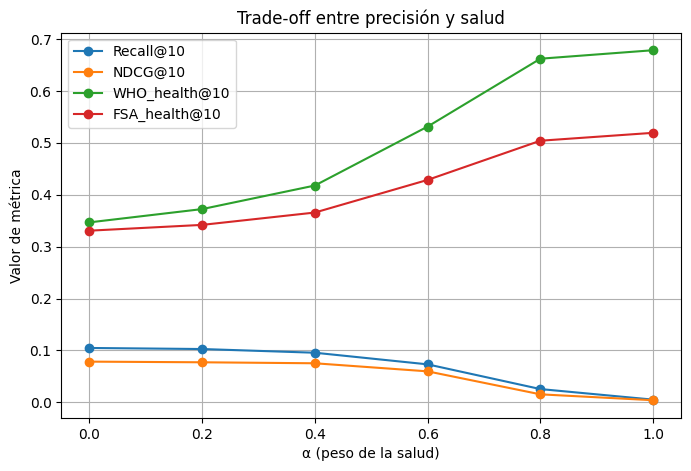

In [ ]:
# Probar distintos α
df_alpha = test_alpha_grid(alpha_list=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                           k=10, k_neighbors=20, health="who")

# Mostrar resultados en tabla
display(df_alpha)

# Graficar trade-off
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(df_alpha["alpha"], df_alpha["Recall@k"], marker='o', label="Recall@10")
plt.plot(df_alpha["alpha"], df_alpha["NDCG@k"], marker='o', label="NDCG@10")
plt.plot(df_alpha["alpha"], df_alpha["WHO_health@k"], marker='o', label="WHO_health@10")
plt.plot(df_alpha["alpha"], df_alpha["FSA_health@k"], marker='o', label="FSA_health@10")
plt.xlabel("α (peso de la salud)")
plt.ylabel("Valor de métrica")
plt.title("Trade-off entre precisión y salud")
plt.legend()
plt.grid(True)
plt.show()


In [90]:
# Obtener los valores de todas las metricas de userKnn sin rerankear:
# Ejemplo con alpha unico

alpha = 0 # Escencialmente es lo mismo que no hacer reranking

# recomendador
recommender_health = lambda u, top_n=10: recommend_userknn_health_blend(
    u, top_n=top_n, k_neighbors=20, health="who", alpha=alpha
)

# Metricas
recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommender_health, k=10)

print(f"Resultados UserKNN+Health (α={alpha:.2f}):")
print(f"  Recall@10       : {recall:.5f}")
print(f"  NDCG@10         : {ndcg:.5f}")
print(f"  WHO_health@10   : {whoH:.5f}")
print(f"  FSA_health@10   : {fsaH:.5f}")


Resultados UserKNN+Health (α=0.00):
  Recall@10       : 0.10465
  NDCG@10         : 0.07831
  WHO_health@10   : 0.34676
  FSA_health@10   : 0.33075


# LightFM

## Modelo base: seteo y evaluación


In [ ]:
# Dataset
lfm_dataset = Dataset()
lfm_dataset.fit(
    users = range(num_users),
    items = range(num_meals)
)

# Interacciones vienen del data_loader del repositorio
interactions = train.ground_truth_u_m.tocoo()


In [ ]:
# Modelo implicito base:
model_lfm = LightFM(
    loss='bpr',
    no_components=64,
    learning_rate=0.05
)
model_lfm.fit(interactions, epochs=20, num_threads=4)

In [ ]:
def recommend_lightfm_base(user_id, top_n=10):
    item_ids = np.arange(num_meals, dtype=np.int32)
    scores = model_lfm.predict(user_id, item_ids, num_threads=4)

    # excluir vistos
    seen = user_seen_meals[user_id]
    if seen:
        scores = scores.copy()
        scores[list(seen)] = -1e9

    top_items = np.argsort(-scores)[:top_n]
    return top_items.tolist()


In [ ]:
# Evaluación base
user_test = defaultdict(list)
for u, m in test.U_M_pairs:
    user_test[u].append(m)

recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommend_lightfm_base, k=10)
print("LightFM (solo interacciones)")
print(" Recall@10     :", recall)
print(" NDCG@10       :", ndcg)
print(" WHO_health@10 :", whoH)
print(" FSA_health@10 :", fsaH)

LightFM (solo interacciones)
 Recall@10     : 0.09529280760440957
 NDCG@10       : 0.06824862228528435
 WHO_health@10 : 0.3434708994708997
 FSA_health@10 : 0.32336507936507963


## Modelo con features

In [ ]:
# Set de nombres de features (con features desde el loader)
item_feature_names = set()

meal_to_courses = {}
for (m, s) in aff.M_S_pairs:
    meal_to_courses.setdefault(m, []).append(s)
    item_feature_names.add(f"course_{s}")

course_to_cat = {}
for (s, c) in cat.S_C_pairs:
    course_to_cat[s] = c
    item_feature_names.add(f"cat_{c}")

# Dataset de LightFM
lfm_dataset = Dataset()
lfm_dataset.fit(
    users = range(num_users),
    items = range(num_meals),
    item_features = list(item_feature_names)
)

# Interacciones
(interactions_f, _) = lfm_dataset.build_interactions(
    ((u, m) for (u, m) in train.U_M_pairs)
)

# Item features
def build_item_features(dataset):
    tuples = []
    for m in range(num_meals):
        feats = []
        if m in meal_to_courses:
            for s in meal_to_courses[m]:
                feats.append(f"course_{s}")
                if s in course_to_cat:
                    feats.append(f"cat_{course_to_cat[s]}")
        tuples.append((m, feats))
    return dataset.build_item_features(tuples)

item_features = build_item_features(lfm_dataset)


In [ ]:
# modelo
model_lfm_feat = LightFM(loss='bpr', no_components=64, learning_rate=0.05)
model_lfm_feat.fit(
    interactions_f,
    item_features=item_features,
    epochs=25,
    num_threads=4
)

In [ ]:
def recommend_lightfm_feat(user_id, top_n=10):
    item_ids = np.arange(num_meals, dtype=np.int32)
    scores = model_lfm_feat.predict(
        user_ids=user_id,
        item_ids=item_ids,
        item_features=item_features,
        num_threads=4
    )
    seen = user_seen_meals[user_id]
    if seen:
        scores = scores.copy()
        scores[list(seen)] = -1e9
    return np.argsort(-scores)[:top_n].tolist()


In [ ]:
# Evaluar
recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommend_lightfm_feat, k=10)
print("LightFM (solo interacciones)")
print(" Recall@10     :", recall)
print(" NDCG@10       :", ndcg)
print(" WHO_health@10 :", whoH)
print(" FSA_health@10 :", fsaH)

LightFM (solo interacciones)
 Recall@10     : 0.11712932082845373
 NDCG@10       : 0.08291654654564443
 WHO_health@10 : 0.35714285714285665
 FSA_health@10 : 0.34159047619047506


## Modelo con datos de salud

In [ ]:
def recommend_lightfm_health_blend(user_id,
                                   top_n=10,
                                   alpha=0.4,
                                   health_vec=None,
                                   candidate_pool=500):
    assert health_vec is not None

    item_ids = np.arange(num_meals, dtype=np.int32)
    scores = model_lfm_feat.predict(
        user_ids=user_id,
        item_ids=item_ids,
        item_features=item_features,
        num_threads=4
    )

    seen = user_seen_meals[user_id]
    scores = scores.copy()
    if seen:
        scores[list(seen)] = -1e9

    # Candidatos por relevancia
    cand_idx = np.argsort(-scores)[:candidate_pool]

    # Normalizar relevancia local
    rel = scores[cand_idx]
    rel_norm = (rel - rel.min()) / (rel.max() - rel.min() + 1e-9)

    # Salud
    health_pool = health_vec[cand_idx]

    # Mezcla
    final = (1 - alpha) * rel_norm + alpha * health_pool

    order = np.argsort(-final)
    return cand_idx[order][:top_n].tolist()


In [ ]:
recommender_lfm_health = lambda u, top_n=10: recommend_lightfm_health_blend(
    u,
    top_n=top_n,
    alpha=0.4,
    health_vec=meal_who_norm  # o meal_fsa_norm
)

recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommender_lfm_health, k=10)
print("LightFM (rerank de salud)")
print(" Recall@10     :", recall)
print(" NDCG@10       :", ndcg)
print(" WHO_health@10 :", whoH)
print(" FSA_health@10 :", fsaH)


LightFM (rerank de salud)
 Recall@10     : 0.10250359219033775
 NDCG@10       : 0.07096836462361744
 WHO_health@10 : 0.4416380952380962
 FSA_health@10 : 0.3823460317460318


# LightGCN

## Definir el procesador:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cpu


## Preparación de los datos


### Pasar pares usuario meals a arrays:

In [ ]:
user_ids = np.array([u for (u, m) in train_pairs], dtype=np.int64)
item_ids = np.array([m for (u, m) in train_pairs], dtype=np.int64)

# Nodos usuarios y comidas
n_users = num_users
n_items = num_meals
n_nodes = n_users + n_items

### Convertir a nodos de pytorch

In [ ]:
# Nodos de usuario: [0, ..., num_users-1]
# Nodos de item: [num_users, ..., num_users+num_meals-1]
user_nodes = torch.from_numpy(user_ids)
item_nodes = torch.from_numpy(item_ids) + n_users

### Construcción del grafo

In [ ]:
# Edges en ambos sentidos (grafo no dirigido)
row = torch.cat([user_nodes, item_nodes], dim=0)
col = torch.cat([item_nodes, user_nodes], dim=0)
edge_index = torch.stack([row, col], dim=0)  # shape (2, 2E)

# Grado de cada nodo para normalización D^{-1/2} A D^{-1/2}
deg = torch.bincount(row, minlength=n_nodes).float()
deg[deg == 0] = 1.0  # evitar división por cero

src, dst = edge_index
norm = 1.0 / torch.sqrt(deg[src] * deg[dst])

# Matriz de adyacencia dispersa normalizada
adj = torch.sparse_coo_tensor(
    edge_index,
    norm,
    size=(n_nodes, n_nodes)
).coalesce().to(device)

## Definición del modelo:

### Definición del modelo:

In [ ]:
class LightGCN(nn.Module):
    def __init__(self, n_nodes, emb_dim=64, n_layers=3):
        super().__init__()
        self.n_nodes = n_nodes
        self.emb_dim = emb_dim
        self.n_layers = n_layers

        # Embeddings iniciales de todos los nodos (usuarios + items)
        self.embedding = nn.Embedding(n_nodes, emb_dim)
        nn.init.normal_(self.embedding.weight, std=0.1)

    def forward(self, adj):
        """
        Propagación de LightGCN:
        x^(0) = embedding inicial
        x^(l+1) = A_hat * x^(l)
        embedding final = promedio de x^(0)...x^(L)
        """
        x = self.embedding.weight  # (n_nodes, emb_dim)
        all_embeddings = [x]

        for _ in range(self.n_layers):
            x = torch.sparse.mm(adj, x)
            all_embeddings.append(x)

        # Promedio de todas las capas (L+1 en total)
        all_embeddings = torch.stack(all_embeddings, dim=0)  # (L+1, n_nodes, emb_dim)
        out = all_embeddings.mean(dim=0)  # (n_nodes, emb_dim)
        return out

    def get_user_item_embeddings(self, adj, n_users, n_items):
        """
        Devuelve:
          user_emb: shape (n_users, emb_dim)
          item_emb: shape (n_items, emb_dim)
        """
        all_emb = self.forward(adj)  # (n_nodes, emb_dim)
        user_emb = all_emb[:n_users]
        item_emb = all_emb[n_users:n_users + n_items]
        return user_emb, item_emb


### BPR loss y muestreo de batches

In [ ]:
def bpr_loss(u_emb, pos_emb, neg_emb, reg_lambda=1e-4):
    """
    BPR: max log σ(ŷ_ui - ŷ_uj)
    """
    pos_scores = (u_emb * pos_emb).sum(dim=1)
    neg_scores = (u_emb * neg_emb).sum(dim=1)
    loss = -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-8).mean()

    # Regularización L2 simple
    reg = (
        u_emb.norm(2).pow(2) +
        pos_emb.norm(2).pow(2) +
        neg_emb.norm(2).pow(2)
    ) / u_emb.size(0)
    return loss + reg_lambda * reg

# Diccionario usuario -> np.array de items positivos
user_pos_items = {
    u: np.array(items, dtype=np.int64)
    for u, items in user_meals.items()
}

all_items = np.arange(n_items, dtype=np.int64)


In [ ]:
def sample_batch(batch_size=2048):
    """
    Muestrea (u, i+, j-) para BPR.
    i+ es un item visto por el usuario
    j- es un item no visto por el usuario
    """
    users = np.random.randint(0, n_users, size=batch_size)
    pos = np.zeros(batch_size, dtype=np.int64)
    neg = np.zeros(batch_size, dtype=np.int64)

    for idx, u in enumerate(users):
        # positivo
        pos_item = np.random.choice(user_pos_items[u])
        pos[idx] = pos_item

        # negativo (no visto)
        while True:
            j = np.random.randint(0, n_items)
            if j not in user_seen_meals[u]:
                neg[idx] = j
                break

    return users, pos, neg

### Entrenar el modelo

In [ ]:
emb_dim = 64
n_layers = 4
model_lgcn = LightGCN(n_nodes=n_nodes, emb_dim=emb_dim, n_layers=n_layers).to(device)
optimizer = optim.Adam(model_lgcn.parameters(), lr=1e-3)

n_epochs = 30       # alterable
batch_size = 2048   # alterable
steps_per_epoch = max(1, len(train_pairs) // batch_size)

for epoch in range(n_epochs):
    model_lgcn.train()
    total_loss = 0.0

    for step in range(steps_per_epoch):
        users, pos_items, neg_items = sample_batch(batch_size)

        users_t = torch.from_numpy(users).long().to(device)
        pos_t = torch.from_numpy(pos_items).long().to(device)
        neg_t = torch.from_numpy(neg_items).long().to(device)

        # Embeddings actuales de usuarios e items
        user_emb, item_emb = model_lgcn.get_user_item_embeddings(adj, n_users, n_items)

        u_emb = user_emb[users_t]       # (B, d)
        pos_emb = item_emb[pos_t]       # (B, d)
        neg_emb = item_emb[neg_t]       # (B, d)

        loss = bpr_loss(u_emb, pos_emb, neg_emb, reg_lambda=1e-4)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / steps_per_epoch
    print(f"Epoch {epoch+1}/{n_epochs} - BPR loss: {avg_loss:.4f}")


Epoch 1/30 - BPR loss: 0.6895
Epoch 2/30 - BPR loss: 0.6881
Epoch 3/30 - BPR loss: 0.6862
Epoch 4/30 - BPR loss: 0.6834
Epoch 5/30 - BPR loss: 0.6791
Epoch 6/30 - BPR loss: 0.6726
Epoch 7/30 - BPR loss: 0.6627
Epoch 8/30 - BPR loss: 0.6494
Epoch 9/30 - BPR loss: 0.6322
Epoch 10/30 - BPR loss: 0.6118
Epoch 11/30 - BPR loss: 0.5894
Epoch 12/30 - BPR loss: 0.5678
Epoch 13/30 - BPR loss: 0.5476
Epoch 14/30 - BPR loss: 0.5293
Epoch 15/30 - BPR loss: 0.5129
Epoch 16/30 - BPR loss: 0.4999
Epoch 17/30 - BPR loss: 0.4901
Epoch 18/30 - BPR loss: 0.4773
Epoch 19/30 - BPR loss: 0.4713
Epoch 20/30 - BPR loss: 0.4604
Epoch 21/30 - BPR loss: 0.4513
Epoch 22/30 - BPR loss: 0.4458
Epoch 23/30 - BPR loss: 0.4397
Epoch 24/30 - BPR loss: 0.4355
Epoch 25/30 - BPR loss: 0.4223
Epoch 26/30 - BPR loss: 0.4154
Epoch 27/30 - BPR loss: 0.4142
Epoch 28/30 - BPR loss: 0.4060
Epoch 29/30 - BPR loss: 0.3979
Epoch 30/30 - BPR loss: 0.3906


### Función de recomendación base:

In [ ]:
@torch.no_grad()
def recommend_lightgcn(user_id, top_n=10):
    """
    Devuelve lista de ids de meals recomendados para user_id
    excluyendo los ya vistos.
    """
    model_lgcn.eval()

    user_emb, item_emb = model_lgcn.get_user_item_embeddings(adj, n_users, n_items)
    u = user_emb[user_id]                      # (d,)
    scores = torch.matmul(item_emb, u)         # (n_items,)

    scores = scores.cpu().numpy()

    # excluir meals ya vistos
    seen = user_seen_meals[user_id]
    if seen:
        scores[list(seen)] = -1e9

    top_items = np.argsort(-scores)[:top_n]
    return top_items.tolist()


### Función de recomendación rerankeada:

In [ ]:
@torch.no_grad()
def recommend_lightgcn_health_blend(user_id,
                                    top_n=10,
                                    alpha=0.4,
                                    health_vec=None,
                                    candidate_pool=500):
    """
    Re-ranking para LightGCN:
      score_final = (1 - alpha)*relevancia + alpha*salud

    - health_vec: vector np.array(num_meals,) con WHO o FSA normalizado
    - alpha: 0 -> solo relevancia, 1 -> solo salud
    """
    assert health_vec is not None, "Debes pasar health_vec (meal_who_norm o meal_fsa_norm)"
    model_lgcn.eval()

    # 1) embeddings actuales de usuarios e ítems
    user_emb, item_emb = model_lgcn.get_user_item_embeddings(adj, n_users, n_items)

    # 2) scores de relevancia (producto punto)
    u = user_emb[user_id]                       # (d,)
    scores = torch.matmul(item_emb, u)         # (n_items,)
    scores = scores.cpu().numpy()

    # 3) excluir ítems ya vistos
    seen = user_seen_meals[user_id]
    if seen:
        scores[list(seen)] = -1e9

    # 4) pool de candidatos por relevancia
    cand_idx = np.argsort(-scores)[:candidate_pool]

    # 5) normalizar relevancia localmente en el pool
    rel = scores[cand_idx]
    rel_norm = (rel - rel.min()) / (rel.max() - rel.min() + 1e-9)

    # 6) tomar salud de los candidatos
    health_pool = health_vec[cand_idx]

    # 7) score final mezcla relevancia + salud
    final = (1.0 - alpha) * rel_norm + alpha * health_pool

    # 8) ordenar por score final y devolver top-n
    order = np.argsort(-final)
    return cand_idx[order][:top_n].tolist()


## Comparación de resultados:

### LighGCN Base:

In [ ]:
recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommend_lightgcn, k=10)

print("LightGCN baseline")
print(" Recall@10     :", recall)
print(" NDCG@10       :", ndcg)
print(" WHO_health@10 :", whoH)
print(" FSA_health@10 :", fsaH)


LightGCN baseline
 Recall@10     : 0.047656553539638456
 NDCG@10       : 0.031512233745965755
 WHO_health@10 : 0.37032804232804184
 FSA_health@10 : 0.2807714285714279


### LightGCN Rerankeado:

In [ ]:
recommender_lgcn_health = lambda u, top_n=10: recommend_lightgcn_health_blend(
    u,
    alpha=0.4,
    top_n=top_n,
    health_vec=meal_who_norm  # o meal_fsa_norm si quieres evaluar FSA
)

recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommender_lgcn_health, k=50)

print(f"LightGCN + reranking salud (α={alpha:.2f})")
print(" Recall@10     :", recall)
print(" NDCG@10       :", ndcg)
print(" WHO_health@10 :", whoH)
print(" FSA_health@10 :", fsaH)

LightGCN + reranking salud (α=0.30)
 Recall@10     : 0.11456713951525192
 NDCG@10       : 0.0489954645768616
 WHO_health@10 : 0.4058835978835977
 FSA_health@10 : 0.3319498412698413


# MultVAE

## Definición del modelo:

### Modelo Base:

In [ ]:
def get_user_interactions(u_ids):
    """
    u_ids: array/list de ids de usuario
    retorna: tensor (batch_size, n_items) float32 en device
    """
    x = user_item_matrix[u_ids].toarray().astype(np.float32)
    x = torch.from_numpy(x).to(device)
    return x


class MultiVAE(nn.Module):
    def __init__(self, n_items, enc_dims=[600, 200], latent_dim=100, dropout=0.5):
        super().__init__()
        self.n_items = n_items
        self.dropout = nn.Dropout(dropout)

        # Encoder
        self.enc_fc1 = nn.Linear(n_items, enc_dims[0])
        self.enc_fc2 = nn.Linear(enc_dims[0], enc_dims[1])
        self.enc_mu = nn.Linear(enc_dims[1], latent_dim)
        self.enc_logvar = nn.Linear(enc_dims[1], latent_dim)

        # Decoder
        self.dec_fc1 = nn.Linear(latent_dim, enc_dims[1])
        self.dec_fc2 = nn.Linear(enc_dims[1], enc_dims[0])
        self.dec_out = nn.Linear(enc_dims[0], n_items)

        self.act = nn.Tanh()

    def encode(self, x):
        h = self.dropout(x)
        h = self.act(self.enc_fc1(h))
        h = self.act(self.enc_fc2(h))
        mu = self.enc_mu(h)
        logvar = self.enc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        eps = torch.randn_like(mu)
        std = torch.exp(0.5 * logvar)
        return mu + eps * std

    def decode(self, z):
        h = self.act(self.dec_fc1(z))
        h = self.act(self.dec_fc2(h))
        logits = self.dec_out(h)  # logits por ítem
        return logits

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        logits = self.decode(z)
        return logits, mu, logvar


def multivae_loss(recon_logits, x, mu, logvar, beta=1.0):
    """
    Pérdida tipo MultiVAE:
      - BCE con logits (reconstrucción)
      - + KL(mu, logvar) ponderado por beta
    """
    # BCE por usuario (sum sobre items)
    bce = nn.functional.binary_cross_entropy_with_logits(
        recon_logits, x, reduction='sum'
    )
    # KL divergence
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = bce + beta * kl
    return loss


### Entrenamiento del modelo:

In [ ]:
model_mvae = MultiVAE(n_items=n_items, enc_dims=[600, 200], latent_dim=100, dropout=0.5).to(device)
optimizer_mvae = optim.Adam(model_mvae.parameters(), lr=1e-3)

batch_size = 256         # ajustable
n_epochs = 30            # ajustable
beta = 0.2               # peso del KL, típico de MultiVAE

user_indices = np.arange(n_users)

for epoch in range(n_epochs):
    model_mvae.train()
    np.random.shuffle(user_indices)

    total_loss = 0.0
    n_batches = int(np.ceil(len(user_indices) / batch_size))

    for b in range(n_batches):
        batch_users = user_indices[b * batch_size:(b + 1) * batch_size]
        x = get_user_interactions(batch_users)  # (batch, n_items)

        recon_logits, mu, logvar = model_mvae(x)
        loss = multivae_loss(recon_logits, x, mu, logvar, beta=beta)

        optimizer_mvae.zero_grad()
        loss.backward()
        optimizer_mvae.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(user_indices)
    print(f"Epoch {epoch+1}/{n_epochs} - loss per user: {avg_loss:.4f}")


Epoch 1/30 - loss per user: 2444.0995
Epoch 2/30 - loss per user: 706.9429
Epoch 3/30 - loss per user: 215.1083
Epoch 4/30 - loss per user: 251.3646
Epoch 5/30 - loss per user: 240.7120
Epoch 6/30 - loss per user: 214.1148
Epoch 7/30 - loss per user: 189.5850
Epoch 8/30 - loss per user: 177.9608
Epoch 9/30 - loss per user: 169.2390
Epoch 10/30 - loss per user: 162.6159
Epoch 11/30 - loss per user: 155.2769
Epoch 12/30 - loss per user: 150.5235
Epoch 13/30 - loss per user: 146.0889
Epoch 14/30 - loss per user: 144.5949
Epoch 15/30 - loss per user: 143.4903
Epoch 16/30 - loss per user: 142.2346
Epoch 17/30 - loss per user: 141.8350
Epoch 18/30 - loss per user: 140.7504
Epoch 19/30 - loss per user: 140.1354
Epoch 20/30 - loss per user: 137.0613
Epoch 21/30 - loss per user: 142.6563
Epoch 22/30 - loss per user: 147.8412
Epoch 23/30 - loss per user: 147.0020
Epoch 24/30 - loss per user: 146.2621
Epoch 25/30 - loss per user: 143.1845
Epoch 26/30 - loss per user: 140.3038
Epoch 27/30 - loss p

### Función de recomendación base:

In [ ]:
@torch.no_grad()
def recommend_multvae(user_id, top_n=10):
    """
    Recomendador base (solo relevancia) usando MultVAE.
    """
    model_mvae.eval()
    x = get_user_interactions(np.array([user_id]))  # (1, n_items)

    logits, mu, logvar = model_mvae(x)
    scores = logits.squeeze(0).cpu().numpy()  # (n_items,)

    # excluir ítems ya vistos
    seen = user_seen_meals[user_id]
    if seen:
        scores[list(seen)] = -1e9

    top_items = np.argsort(-scores)[:top_n]
    return top_items.tolist()

### Función de recomendación rerankeada

In [ ]:
def recommend_multvae_health_blend(user_id,
                                   top_n=10,
                                   alpha=0.3,
                                   health_vec=None,
                                   candidate_pool=500):
    """
    Re-ranking para MultVAE:
      score_final = (1 - alpha)*relevancia + alpha*salud

    - health_vec: np.array(num_meals,) con WHO o FSA normalizado
    - alpha: 0 -> solo relevancia, 1 -> solo salud
    """
    assert health_vec is not None, "Debes pasar health_vec (meal_who_norm o meal_fsa_norm)"

    model_mvae.eval()
    x = get_user_interactions(np.array([user_id]))  # (1, n_items)

    logits, mu, logvar = model_mvae(x)
    scores = logits.squeeze(0).detach().cpu().numpy()  # relevancia por ítem

    # excluir ítems ya vistos
    seen = user_seen_meals[user_id]
    if seen:
        scores[list(seen)] = -1e9

    # pool de candidatos por relevancia
    cand_idx = np.argsort(-scores)[:candidate_pool]

    # normalizar relevancia localmente
    rel = scores[cand_idx]
    rel_norm = (rel - rel.min()) / (rel.max() - rel.min() + 1e-9)

    # salud en el pool
    health_pool = health_vec[cand_idx]

    # mezcla
    final = (1.0 - alpha) * rel_norm + alpha * health_pool

    order = np.argsort(-final)
    return cand_idx[order][:top_n].tolist()

## Comparación de resultados:

### MultVAE base:

In [ ]:
# Evaluar MultVAE base
recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommend_multvae, k=50)

print("MultVAE baseline")
print(" Recall@10     :", recall)
print(" NDCG@10       :", ndcg)
print(" WHO_health@10 :", whoH)
print(" FSA_health@10 :", fsaH)

MultVAE baseline
 Recall@10     : 0.09262740402581489
 NDCG@10       : 0.035256375513730426
 WHO_health@10 : 0.34289862433862406
 FSA_health@10 : 0.3022615873015869


MultVAE rerankeado:

In [ ]:
alpha = 0.4  # ajusta para ver el trade-off precisión vs salud

recommender_mvae_health = lambda u, top_n=10: recommend_multvae_health_blend(
    u,
    top_n=top_n,
    alpha=alpha,
    health_vec=meal_who_norm   # o meal_fsa_norm
)

recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommender_mvae_health, k=5)

print(f"MultVAE + reranking salud (α={alpha:.2f})")
print(" Recall@10     :", recall)
print(" NDCG@10       :", ndcg)
print(" WHO_health@10 :", whoH)
print(" FSA_health@10 :", fsaH)


MultVAE + reranking salud (α=0.40)
 Recall@10     : 0.01699268446305918
 NDCG@10       : 0.015645645459184933
 WHO_health@10 : 0.4276740740740684
 FSA_health@10 : 0.275473015873011


# DeepFM

Se va a implementar DeepFm con las siguientes features:


*   Features de usuario: user_who; user_fsa
*   Features de Meal: meal_who; meal_fsa
*   Curso de Meal: course_who; course_fsa
*   Categoria del curso del Meal: 0 = Appetizer, 1 = Main, 2 = Dessert



## Cargar los datos faltantes

### Cargar datos de user y de cursos

In [ ]:
def load_user_scores(base_path=".", dataset_name="MealRec+H", kind="who"):
    assert kind in ("who", "fsa")
    fname = f"user_{kind}.txt"
    file_path = os.path.join(base_path, dataset_name, "healthiness", fname)
    vals = []
    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if line == "":
                vals.append(np.nan)
            else:
                parts = line.split('\t')
                vals.append(float(parts[0]))
    return np.array(vals, dtype=float)

def load_course_scores(base_path=".", dataset_name="MealRec+H", kind="who"):
    assert kind in ("who", "fsa")
    fname = f"course_{kind}.txt"
    file_path = os.path.join(base_path, dataset_name, "healthiness", fname)
    vals = []
    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if line == "":
                vals.append(np.nan)
            else:
                parts = line.split('\t')
                vals.append(float(parts[0]))
    return np.array(vals, dtype=float)

# ya tienes normalize_health_scores definido antes
user_who_raw = load_user_scores(base_path=".", dataset_name="MealRec+H", kind="who")
user_fsa_raw = load_user_scores(base_path=".", dataset_name="MealRec+H", kind="fsa")
course_who_raw = load_course_scores(base_path=".", dataset_name="MealRec+H", kind="who")
course_fsa_raw = load_course_scores(base_path=".", dataset_name="MealRec+H", kind="fsa")

user_who_norm = normalize_health_scores(user_who_raw, invert_lower_is_healthier=True)
user_fsa_norm = normalize_health_scores(user_fsa_raw, invert_lower_is_healthier=False)
course_who_norm = normalize_health_scores(course_who_raw, invert_lower_is_healthier=True)
course_fsa_norm = normalize_health_scores(course_fsa_raw, invert_lower_is_healthier=False)


### Agregar WHO/FSA de cursos a cada meal

In [ ]:
meal_course_who = np.zeros(num_meals, dtype=np.float32)
meal_course_fsa = np.zeros(num_meals, dtype=np.float32)

global_cwho = np.nanmean(course_who_norm)
global_cfsa = np.nanmean(course_fsa_norm)

for m in range(num_meals):
    courses = meal_to_courses.get(m, [])
    if courses:
        meal_course_who[m] = float(np.mean(course_who_norm[courses]))
        meal_course_fsa[m] = float(np.mean(course_fsa_norm[courses]))
    else:
        meal_course_who[m] = global_cwho
        meal_course_fsa[m] = global_cfsa




### Categoria por meal (agregando categoria desconocida = 3)

In [ ]:
# Antes estaba definido meal_to_cat usando course_to_cat
# meal_to_cat[m] = c (0,1,2) para platos con categoría

num_base_cats = 3   # 0,1,2 del dataset
UNKNOWN_CAT = 3
num_categories = num_base_cats + 1  # 4, agregamos "desconocida"

meal_cat_ids = np.full(num_meals, UNKNOWN_CAT, dtype=np.int64)
for m, c in meal_to_cat.items():
    if c in [0, 1, 2]:
        meal_cat_ids[m] = c

### Features densas finales

In [ ]:
user_dense = np.stack([user_who_norm, user_fsa_norm], axis=1).astype(np.float32)   # (num_users, 2)

# Ítem (meal):
# [meal_who_norm, meal_fsa_norm, meal_course_who, meal_course_fsa]
meal_item_dense = np.stack(
    [meal_who_norm, meal_fsa_norm, meal_course_who, meal_course_fsa],
    axis=1
).astype(np.float32)   # (num_meals, 4)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DeepFM usará device:", device)

user_dense_tensor = torch.from_numpy(user_dense).to(device)               # (num_users, 2)
meal_item_dense_tensor = torch.from_numpy(meal_item_dense).to(device)     # (num_meals, 4)
meal_cat_tensor = torch.from_numpy(meal_cat_ids).long().to(device)        # (num_meals,)

DeepFM usará device: cpu


## Definir el modelo

In [ ]:
class DeepFM(nn.Module):
    def __init__(self,
                 num_users,
                 num_items,
                 num_categories,
                 emb_dim=32,
                 mlp_hidden_dims=[128, 64],
                 dropout=0.2):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_categories = num_categories
        self.emb_dim = emb_dim

        # --- Embeddings para IDs ---
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        self.cat_emb = nn.Embedding(num_categories, emb_dim)  # categorías 0,1,2 + unknown=3

        # --- Proyección de features densas a embeddings (para FM) ---
        self.user_dense_emb = nn.Linear(2, emb_dim)   # [user_who, user_fsa]
        self.item_dense_emb = nn.Linear(4, emb_dim)   # [meal_who, meal_fsa, course_who, course_fsa]

        # --- Parte lineal (1er orden) ---
        self.linear_user = nn.Embedding(num_users, 1)
        self.linear_item = nn.Embedding(num_items, 1)
        self.linear_cat  = nn.Embedding(num_categories, 1)
        self.linear_user_dense = nn.Linear(2, 1)
        self.linear_item_dense = nn.Linear(4, 1)

        # --- Parte Deep (MLP) ---
        # input: concat(user_emb, item_emb, cat_emb, user_dense_raw, item_dense_raw)
        input_dim = emb_dim * 3 + 2 + 4
        layers = []
        for h in mlp_hidden_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = h
        layers.append(nn.Linear(input_dim, 1))
        self.mlp = nn.Sequential(*layers)

        # Inicialización simple
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)

    def fm_second_order(self, *embs):
        """
        FM de 2º orden sobre embeddings de campos:
        embs: lista de tensores (B, k)
        """
        v = torch.stack(embs, dim=1)  # (B, F, k) donde F = número de campos
        sum_v = torch.sum(v, dim=1)         # (B, k)
        sum_v_square = sum_v * sum_v

        square_v = v * v
        square_sum = torch.sum(square_v, dim=1)

        fm_second = 0.5 * (sum_v_square - square_sum)  # (B, k)
        return fm_second.sum(dim=1, keepdim=True)      # (B, 1)

    def forward(self, user_ids, item_ids, cat_ids, user_dense, item_dense):
        """
        user_ids: (B,)
        item_ids: (B,)
        cat_ids: (B,)
        user_dense: (B, 2) -> [user_who, user_fsa]
        item_dense: (B, 4) -> [meal_who, meal_fsa, course_who, course_fsa]
        """
        # Embeddings de IDs
        u_e = self.user_emb(user_ids)      # (B, k)
        i_e = self.item_emb(item_ids)      # (B, k)
        c_e = self.cat_emb(cat_ids)        # (B, k)

        # Embeddings de features densas
        ud_e = self.user_dense_emb(user_dense)   # (B, k)
        it_e = self.item_dense_emb(item_dense)   # (B, k)

        # Parte lineal
        lin_u  = self.linear_user(user_ids)          # (B,1)
        lin_i  = self.linear_item(item_ids)          # (B,1)
        lin_c  = self.linear_cat(cat_ids)            # (B,1)
        lin_ud = self.linear_user_dense(user_dense)  # (B,1)
        lin_it = self.linear_item_dense(item_dense)  # (B,1)
        linear_part = lin_u + lin_i + lin_c + lin_ud + lin_it  # (B,1)

        # FM segundo orden entre campos
        fm_part = self.fm_second_order(u_e, i_e, c_e, ud_e, it_e)  # (B,1)

        # Deep part
        deep_in = torch.cat([u_e, i_e, c_e, user_dense, item_dense], dim=1)  # (B, 3k+6)
        deep_out = self.mlp(deep_in)  # (B,1)

        logit = linear_part + fm_part + deep_out  # (B,1)
        return logit.squeeze(1)  # (B,)


## Entrenar el modelo (con perdida BPR)

In [ ]:
def bpr_loss_pref_health(pos_scores, neg_scores,
                         pos_health, neg_health,
                         lambda_health=0.3,
                         reg_lambda=1e-5,
                         model=None):
    """
    pos_scores, neg_scores: scores del modelo (B,)
    pos_health, neg_health: salud normalizada (B,), ej. FSA
    lambda_health: cuánto peso le damos a la salud en la loss
    """

    # 1) PREFERENCIAS (BPR clásico: ítems con interacción > ítems negativos)
    loss_pref = -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-8).mean()

    # 2) SALUD: queremos que los ítems positivos sean más saludables que los negativos
    #    (BPR pero sobre los health_scores)
    loss_health = -torch.log(torch.sigmoid(pos_health - neg_health) + 1e-8).mean()

    loss = loss_pref + lambda_health * loss_health

    # 3) Regularización L2 (opcional)
    if model is not None and reg_lambda > 0.0:
        l2 = 0.0
        for p in model.parameters():
            l2 += p.norm(2).pow(2)
        loss = loss + reg_lambda * l2 / pos_scores.size(0)

    return loss


In [ ]:
def bpr_loss_scores(pos_scores,
                    neg_scores,
                    pos_health,
                    neg_health,
                    lambda_health=0.4,
                    reg_lambda=1e-5,
                    model=None):
    """
    pos_scores, neg_scores: scores de DeepFM (B,)
    pos_health, neg_health: salud normalizada de los ítems (B,)
        p.ej. FSA o WHO en [0,1], donde MAYOR = más saludable

    lambda_health: peso del término de salud en la loss
    """

    # 1) BPR clásico (preferencia):
    loss_pref = -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-8).mean()

    # 2) BPR en salud: queremos que los positivos sean MÁS saludables
    loss_health = -torch.log(torch.sigmoid(pos_health - neg_health) + 1e-8).mean()

    loss = loss_pref + lambda_health * loss_health

    # 3) Regularización L2 (igual que antes)
    if model is not None and reg_lambda > 0.0:
        l2 = 0.0
        for p in model.parameters():
            l2 += p.norm(2).pow(2)
        loss = loss + reg_lambda * l2 / pos_scores.size(0)

    return loss


deepfm_ext = DeepFM(
    num_users=num_users,
    num_items=num_meals,
    num_categories=num_categories,
    emb_dim=32,
    mlp_hidden_dims=[128, 64],
    dropout=0.2
).to(device)

optimizer_deepfm_ext = torch.optim.Adam(deepfm_ext.parameters(), lr=1e-3)

n_epochs = 20
batch_size = 2048
steps_per_epoch = max(1, len(train_pairs) // batch_size)

for epoch in range(n_epochs):
    deepfm_ext.train()
    total_loss = 0.0

    for step in range(steps_per_epoch):
        users, pos_items, neg_items = sample_batch(batch_size) # Misma funcion definida para lightGcn

        users_t = torch.from_numpy(users).long().to(device)
        pos_t   = torch.from_numpy(pos_items).long().to(device)
        neg_t   = torch.from_numpy(neg_items).long().to(device)

        # features del usuario
        u_dense = user_dense_tensor[users_t]              # (B,2)

        # features del ítem positivo
        pos_dense = meal_item_dense_tensor[pos_t]         # (B,4)
        pos_cat   = meal_cat_tensor[pos_t]                # (B,)

        # features del ítem negativo
        neg_dense = meal_item_dense_tensor[neg_t]         # (B,4)
        neg_cat   = meal_cat_tensor[neg_t]                # (B,)

        pos_scores = deepfm_ext(users_t, pos_t, pos_cat, u_dense, pos_dense)
        neg_scores = deepfm_ext(users_t, neg_t, neg_cat, u_dense, neg_dense)

        # -------- NUEVO: salud desde los dense features --------
        # meal_item_dense = [meal_who_norm, meal_fsa_norm, meal_course_who, meal_course_fsa]
        # Usa FSA (columna 1) como objetivo de salud:
        pos_health = pos_dense[:, 1]   # (B,)
        neg_health = neg_dense[:, 1]   # (B,)

        # Si quisieras usar WHO:
        # pos_health = pos_dense[:, 0]
        # neg_health = neg_dense[:, 0]

        # O combinar ambas (ejemplo):
        # pos_health = 0.5 * (pos_dense[:,0] + pos_dense[:,1])
        # neg_health = 0.5 * (neg_dense[:,0] + neg_dense[:,1])

        loss = bpr_loss_scores(
            pos_scores,
            neg_scores,
            pos_health,
            neg_health,
            lambda_health=0.3,   # prueba con 0.3, 0.5, etc.
            reg_lambda=1e-6,
            model=deepfm_ext
        )

        optimizer_deepfm_ext.zero_grad()
        loss.backward()
        optimizer_deepfm_ext.step()

        total_loss += loss.item()

    avg_loss = total_loss / steps_per_epoch
    print(f"[DeepFMExtended] Epoch {epoch+1}/{n_epochs} - BPR loss: {avg_loss:.4f}")


[DeepFMExtended] Epoch 1/20 - BPR loss: 1.0633
[DeepFMExtended] Epoch 2/20 - BPR loss: 0.9034
[DeepFMExtended] Epoch 3/20 - BPR loss: 0.7796
[DeepFMExtended] Epoch 4/20 - BPR loss: 0.7019
[DeepFMExtended] Epoch 5/20 - BPR loss: 0.6844
[DeepFMExtended] Epoch 6/20 - BPR loss: 0.6709
[DeepFMExtended] Epoch 7/20 - BPR loss: 0.6617
[DeepFMExtended] Epoch 8/20 - BPR loss: 0.6482
[DeepFMExtended] Epoch 9/20 - BPR loss: 0.6382
[DeepFMExtended] Epoch 10/20 - BPR loss: 0.6338
[DeepFMExtended] Epoch 11/20 - BPR loss: 0.6224
[DeepFMExtended] Epoch 12/20 - BPR loss: 0.6136
[DeepFMExtended] Epoch 13/20 - BPR loss: 0.6085
[DeepFMExtended] Epoch 14/20 - BPR loss: 0.5997
[DeepFMExtended] Epoch 15/20 - BPR loss: 0.5798
[DeepFMExtended] Epoch 16/20 - BPR loss: 0.5752
[DeepFMExtended] Epoch 17/20 - BPR loss: 0.5602
[DeepFMExtended] Epoch 18/20 - BPR loss: 0.5452
[DeepFMExtended] Epoch 19/20 - BPR loss: 0.5285
[DeepFMExtended] Epoch 20/20 - BPR loss: 0.5141


## Función de recomendación

In [ ]:
@torch.no_grad()
def recommend_deepfm(user_id, top_n=10):
    deepfm_ext.eval()

    # Todos los ítems
    item_ids = torch.arange(num_meals, dtype=torch.long, device=device)  # (N_items,)
    user_ids = torch.full_like(item_ids, fill_value=user_id, dtype=torch.long, device=device)

    # features
    u_dense = user_dense_tensor[user_id].unsqueeze(0).expand(num_meals, -1)   # (N_items, 2)
    i_dense = meal_item_dense_tensor[item_ids]                                # (N_items, 4)
    i_cat   = meal_cat_tensor[item_ids]                                       # (N_items,)

    scores = deepfm_ext(user_ids, item_ids, i_cat, u_dense, i_dense)         # (N_items,)
    scores = scores.detach().cpu().numpy()

    # excluir meals ya vistos por el usuario
    seen = user_seen_meals[user_id]
    if seen:
        scores[list(seen)] = -1e9

    top_items = np.argsort(-scores)[:top_n]
    return top_items.tolist()


## Evaluación final:

In [ ]:
recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommend_deepfm, k=10)

print("DeepFM con las features user + meal + curso + cat + salud")
print(" Recall@10     :", recall)
print(" NDCG@10       :", ndcg)
print(" WHO_health@10 :", whoH)
print(" FSA_health@10 :", fsaH)

DeepFM con las features user + meal + curso + cat + salud
 Recall@10     : 0.025368751123493717
 NDCG@10       : 0.01738141252221133
 WHO_health@10 : 0.34481269841269874
 FSA_health@10 : 0.3461968253968247


# Comparación final:


Aca hay una comparación final de los valores de los recomendadores propuestos. Estos son SOLO las versiones RERANKEADAS, quizá vale la pena observar valroes base también.

UserKNN:

In [ ]:
recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommender_health, k=10)

print(f"Resultados UserKNN+Health (α={alpha:.2f}):")
print(f"  Recall@10       : {recall:.4f}")
print(f"  NDCG@10         : {ndcg:.4f}")
print(f"  WHO_health@10   : {whoH:.4f}")
print(f"  FSA_health@10   : {fsaH:.4f}")

Resultados UserKNN+Health (α=0.40):
  Recall@10       : 0.0955
  NDCG@10         : 0.0751
  WHO_health@10   : 0.4178
  FSA_health@10   : 0.3657


LightFM:

In [ ]:
recommender_lfm_health = lambda u, top_n=10: recommend_lightfm_health_blend(
    u,
    top_n=top_n,
    alpha=0.4,
    health_vec=meal_who_norm  # o meal_fsa_norm
)

recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommender_lfm_health, k=5)
print("LightFM (rerank de salud)")
print(" Recall@10     :", recall)
print(" NDCG@10       :", ndcg)
print(" WHO_health@10 :", whoH)
print(" FSA_health@10 :", fsaH)

LightFM (rerank de salud)
 Recall@10     : 0.06607381645746717
 NDCG@10       : 0.060393784408774284
 WHO_health@10 : 0.4497777777777784
 FSA_health@10 : 0.3857079365079359


LightGCN:

In [ ]:
recommender_lgcn_health = lambda u, top_n=10: recommend_lightgcn_health_blend(
    u,
    alpha=0.4,
    top_n=top_n,
    health_vec=meal_who_norm  # o meal_fsa_norm si quieres evaluar FSA
)

recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommender_lgcn_health, k=10)

print(f"LightGCN + reranking salud (α={alpha:.2f})")
print(" Recall@10     :", recall)
print(" NDCG@10       :", ndcg)
print(" WHO_health@10 :", whoH)
print(" FSA_health@10 :", fsaH)

LightGCN + reranking salud (α=0.40)
 Recall@10     : 0.04313759850717855
 NDCG@10       : 0.030102056160200178
 WHO_health@10 : 0.4216846560846543
 FSA_health@10 : 0.29105396825396646


MultVAE:

In [ ]:
alpha = 0.4  # ajusta para ver el trade-off precisión vs salud

recommender_mvae_health = lambda u, top_n=10: recommend_multvae_health_blend(
    u,
    top_n=top_n,
    alpha=alpha,
    health_vec=meal_who_norm   # o meal_fsa_norm
)

recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommender_mvae_health, k=10)

print(f"MultVAE + reranking salud (α={alpha:.2f})")
print(" Recall@10     :", recall)
print(" NDCG@10       :", ndcg)
print(" WHO_health@10 :", whoH)
print(" FSA_health@10 :", fsaH)

MultVAE + reranking salud (α=0.40)
 Recall@10     : 0.02699463300334856
 NDCG@10       : 0.0190119569018446
 WHO_health@10 : 0.4049777777777767
 FSA_health@10 : 0.2823968253968178


DeepFM:

In [ ]:
recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommend_deepfm, k=10)

print("DeepFM con las features user + meal + curso + cat + salud")
print(" Recall@10     :", recall)
print(" NDCG@10       :", ndcg)
print(" WHO_health@10 :", whoH)
print(" FSA_health@10 :", fsaH)

DeepFM con las features user + meal + curso + cat + salud
 Recall@10     : 0.025368751123493717
 NDCG@10       : 0.01738141252221133
 WHO_health@10 : 0.34481269841269874
 FSA_health@10 : 0.3461968253968247


# Gráficos


Rerankeando con WHO

In [ ]:
import pandas as pd

# Ajusta estos alphas si quieres probar otros
ALPHA_USERKNN = 0.4
ALPHA_LFM     = 0.4
ALPHA_LGCN    = 0.4
ALPHA_MVAE    = 0.4

models = []

# UserKNN + salud (WHO por ejemplo)
recommender_userknn = lambda u, top_n=10: recommend_userknn_health_blend(
    u,
    top_n=top_n,
    k_neighbors=20,
    health="who",      # o "fsa" si quieres basar el reranking en FSA
    alpha=ALPHA_USERKNN,
)
recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommender_userknn, k=10)
models.append({
    "modelo": f"UserKNN+Health (α={ALPHA_USERKNN:.2f})",
    "Recall@10": recall,
    "NDCG@10": ndcg,
    "WHO_health@10": whoH,
    "FSA_health@10": fsaH,
})

# LightFM + reranking salud
recommender_lfm = lambda u, top_n=10: recommend_lightfm_health_blend(
    u,
    top_n=top_n,
    alpha=ALPHA_LFM,
    health_vec=meal_who_norm,   # o meal_fsa_norm si quieres
    candidate_pool=500,
)
recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommender_lfm, k=10)
models.append({
    "modelo": f"LightFM+Health (α={ALPHA_LFM:.2f})",
    "Recall@10": recall,
    "NDCG@10": ndcg,
    "WHO_health@10": whoH,
    "FSA_health@10": fsaH,
})

# LightGCN + reranking salud
recommender_lgcn = lambda u, top_n=10: recommend_lightgcn_health_blend(
    u,
    top_n=top_n,
    alpha=ALPHA_LGCN,
    health_vec=meal_who_norm,   # o meal_fsa_norm
    candidate_pool=500,
)
recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommender_lgcn, k=10)
models.append({
    "modelo": f"LightGCN+Health (α={ALPHA_LGCN:.2f})",
    "Recall@10": recall,
    "NDCG@10": ndcg,
    "WHO_health@10": whoH,
    "FSA_health@10": fsaH,
})

# MultVAE + reranking salud
recommender_mvae = lambda u, top_n=10: recommend_multvae_health_blend(
    u,
    top_n=top_n,
    alpha=ALPHA_MVAE,
    health_vec=meal_who_norm,   # o meal_fsa_norm
    candidate_pool=500,
)
recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommender_mvae, k=10)
models.append({
    "modelo": f"MultVAE+Health (α={ALPHA_MVAE:.2f})",
    "Recall@10": recall,
    "NDCG@10": ndcg,
    "WHO_health@10": whoH,
    "FSA_health@10": fsaH,
})

# DeepFM (no usa alpha, ya incluye salud como features)
recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommend_deepfm, k=10)
models.append({
    "modelo": "DeepFM (features salud)",
    "Recall@10": recall,
    "NDCG@10": ndcg,
    "WHO_health@10": whoH,
    "FSA_health@10": fsaH,
})

df = pd.DataFrame(models)
df_round = df.copy()
for col in ["Recall@10", "NDCG@10", "WHO_health@10", "FSA_health@10"]:
    df_round[col] = df_round[col].round(4)

df_round

,modelo,Recall@10,NDCG@10,WHO_health@10,FSA_health@10
0,UserKNN+Health (α=0.40),0.0955,0.0751,0.4178,0.3657
1,LightFM+Health (α=0.40),0.1025,0.0710,0.4416,0.3823
2,LightGCN+Health (α=0.40),0.0431,0.0301,0.4217,0.2911
3,MultVAE+Health (α=0.40),0.0278,0.0193,0.4053,0.2822
4,DeepFM (features salud),0.0254,0.0174,0.3448,0.3462


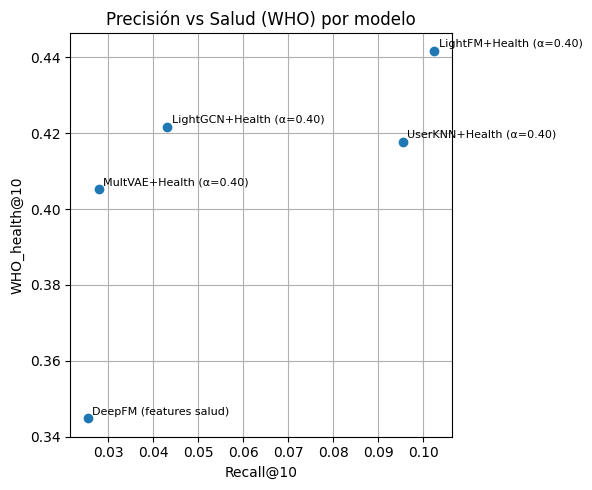

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df["Recall@10"], df["WHO_health@10"])

for _, row in df.iterrows():
    plt.text(
        row["Recall@10"] + 0.001,
        row["WHO_health@10"] + 0.001,
        row["modelo"],
        fontsize=8,
    )

plt.xlabel("Recall@10")
plt.ylabel("WHO_health@10")
plt.title("Precisión vs Salud (WHO) por modelo")
plt.grid(True)
plt.tight_layout()
plt.show()

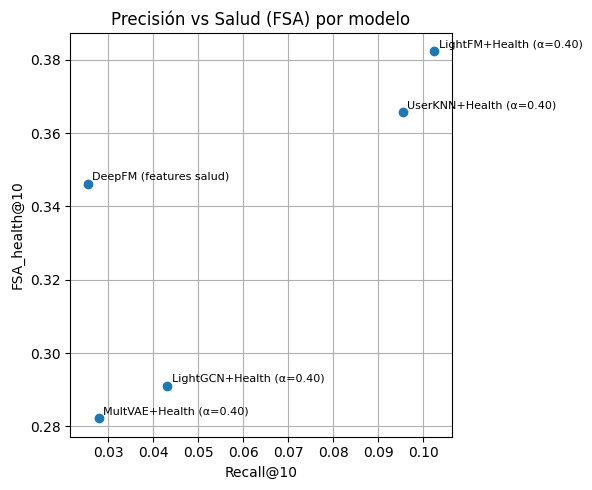

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df["Recall@10"], df["FSA_health@10"])

for _, row in df.iterrows():
    plt.text(
        row["Recall@10"] + 0.001,
        row["FSA_health@10"] + 0.001,
        row["modelo"],
        fontsize=8,
    )

plt.xlabel("Recall@10")
plt.ylabel("FSA_health@10")
plt.title("Precisión vs Salud (FSA) por modelo")
plt.grid(True)
plt.tight_layout()
plt.show()

Rerankeando con FSA

In [ ]:
import pandas as pd

# Ajusta estos alphas si quieres probar otros
ALPHA_USERKNN = 0.4
ALPHA_LFM     = 0.4
ALPHA_LGCN    = 0.4
ALPHA_MVAE    = 0.4

models = []

# UserKNN + salud (fsa)
recommender_userknn = lambda u, top_n=10: recommend_userknn_health_blend(
    u,
    top_n=top_n,
    k_neighbors=20,
    health="fsa",
    alpha=ALPHA_USERKNN,
)
recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommender_userknn, k=10)
models.append({
    "modelo": f"UserKNN+Health (α={ALPHA_USERKNN:.2f})",
    "Recall@10": recall,
    "NDCG@10": ndcg,
    "WHO_health@10": whoH,
    "FSA_health@10": fsaH,
})

# LightFM + reranking salud
recommender_lfm = lambda u, top_n=10: recommend_lightfm_health_blend(
    u,
    top_n=top_n,
    alpha=ALPHA_LFM,
    health_vec=meal_fsa_norm,
    candidate_pool=500,
)
recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommender_lfm, k=10)
models.append({
    "modelo": f"LightFM+Health (α={ALPHA_LFM:.2f})",
    "Recall@10": recall,
    "NDCG@10": ndcg,
    "WHO_health@10": whoH,
    "FSA_health@10": fsaH,
})

# LightGCN + reranking salud
recommender_lgcn = lambda u, top_n=10: recommend_lightgcn_health_blend(
    u,
    top_n=top_n,
    alpha=ALPHA_LGCN,
    health_vec=meal_fsa_norm,
    candidate_pool=500,
)
recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommender_lgcn, k=10)
models.append({
    "modelo": f"LightGCN+Health (α={ALPHA_LGCN:.2f})",
    "Recall@10": recall,
    "NDCG@10": ndcg,
    "WHO_health@10": whoH,
    "FSA_health@10": fsaH,
})

# MultVAE + reranking salud
recommender_mvae = lambda u, top_n=10: recommend_multvae_health_blend(
    u,
    top_n=top_n,
    alpha=ALPHA_MVAE,
    health_vec=meal_fsa_norm,
    candidate_pool=500,
)
recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommender_mvae, k=10)
models.append({
    "modelo": f"MultVAE+Health (α={ALPHA_MVAE:.2f})",
    "Recall@10": recall,
    "NDCG@10": ndcg,
    "WHO_health@10": whoH,
    "FSA_health@10": fsaH,
})

# DeepFM (no usa alpha, ya incluye salud como features)
recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(recommend_deepfm, k=10)
models.append({
    "modelo": "DeepFM (features salud)",
    "Recall@10": recall,
    "NDCG@10": ndcg,
    "WHO_health@10": whoH,
    "FSA_health@10": fsaH,
})

df = pd.DataFrame(models)
df_round = df.copy()
for col in ["Recall@10", "NDCG@10", "WHO_health@10", "FSA_health@10"]:
    df_round[col] = df_round[col].round(4)

df_round

,modelo,Recall@10,NDCG@10,WHO_health@10,FSA_health@10
0,UserKNN+Health (α=0.40),0.0911,0.0714,0.3850,0.4304
1,LightFM+Health (α=0.40),0.1007,0.0725,0.4015,0.4365
2,LightGCN+Health (α=0.40),0.0410,0.0277,0.3983,0.3976
3,MultVAE+Health (α=0.40),0.0217,0.0164,0.4143,0.4104
4,DeepFM (features salud),0.0254,0.0174,0.3448,0.3462


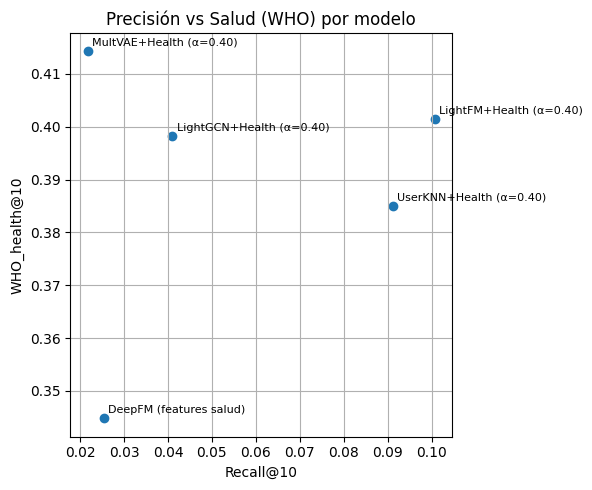

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df["Recall@10"], df["WHO_health@10"])

for _, row in df.iterrows():
    plt.text(
        row["Recall@10"] + 0.001,
        row["WHO_health@10"] + 0.001,
        row["modelo"],
        fontsize=8,
    )

plt.xlabel("Recall@10")
plt.ylabel("WHO_health@10")
plt.title("Precisión vs Salud (WHO) por modelo")
plt.grid(True)
plt.tight_layout()
plt.show()

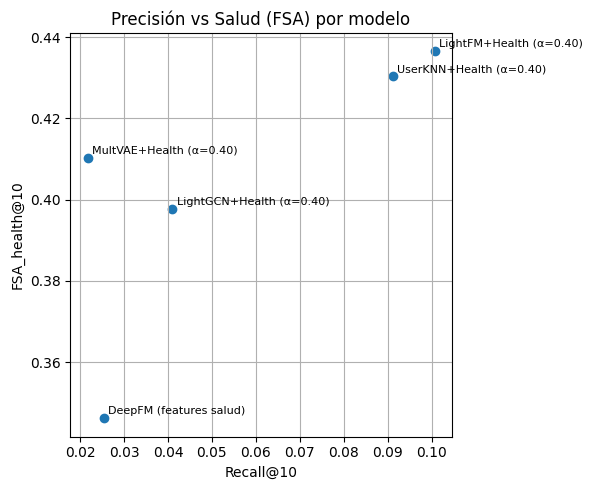

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df["Recall@10"], df["FSA_health@10"])

for _, row in df.iterrows():
    plt.text(
        row["Recall@10"] + 0.001,
        row["FSA_health@10"] + 0.001,
        row["modelo"],
        fontsize=8,
    )

plt.xlabel("Recall@10")
plt.ylabel("FSA_health@10")
plt.title("Precisión vs Salud (FSA) por modelo")
plt.grid(True)
plt.tight_layout()
plt.show()

LightFM comparación de alfas

In [ ]:
import numpy as np
import pandas as pd

def sweep_alpha_lightfm(alpha_list, k=10, health_vec=None, candidate_pool=500):
    """
    Barre distintos valores de α para LightFM+Health y devuelve un DataFrame
    con Recall@k, NDCG@k, WHO_health@k y FSA_health@k.

    health_vec: normalmente meal_who_norm o meal_fsa_norm
    """
    assert health_vec is not None, "Debes pasar health_vec (meal_who_norm o meal_fsa_norm)"

    results = []
    for alpha in alpha_list:
        print(f"Evaluando LightFM con α={alpha:.2f} ...")

        rec_fun = lambda u, top_n=10: recommend_lightfm_health_blend(
            u,
            top_n=top_n,
            alpha=alpha,
            health_vec=health_vec,
            candidate_pool=candidate_pool,
        )

        recall, ndcg, whoH, fsaH = evaluate_recommender_metrics(rec_fun, k=k)
        results.append({
            "alpha": alpha,
            "Recall@k": recall,
            "NDCG@k": ndcg,
            "WHO_health@k": whoH,
            "FSA_health@k": fsaH,
        })
        print(f"  Recall={recall:.4f}, NDCG={ndcg:.4f}, WHO={whoH:.4f}, FSA={fsaH:.4f}")

    return pd.DataFrame(results)

# Define los alphas que quieres probar
alpha_values = np.linspace(0.0, 1.0, 11)  # 0.00, 0.10, 0.20, ..., 1.00

# Barrido usando WHO como vector de salud
df_lfm_alpha_who = sweep_alpha_lightfm(alpha_values, k=10, health_vec=meal_who_norm)
df_lfm_alpha_who

Evaluando LightFM con α=0.00 ...
  Recall=0.1171, NDCG=0.0829, WHO=0.3571, FSA=0.3416
Evaluando LightFM con α=0.10 ...
  Recall=0.1169, NDCG=0.0820, WHO=0.3718, FSA=0.3478
Evaluando LightFM con α=0.20 ...
  Recall=0.1150, NDCG=0.0802, WHO=0.3878, FSA=0.3555
Evaluando LightFM con α=0.30 ...
  Recall=0.1083, NDCG=0.0749, WHO=0.4093, FSA=0.3660
Evaluando LightFM con α=0.40 ...
  Recall=0.1025, NDCG=0.0710, WHO=0.4416, FSA=0.3823
Evaluando LightFM con α=0.50 ...
  Recall=0.0881, NDCG=0.0602, WHO=0.4838, FSA=0.4035
Evaluando LightFM con α=0.60 ...
  Recall=0.0729, NDCG=0.0471, WHO=0.5440, FSA=0.4354
Evaluando LightFM con α=0.70 ...
  Recall=0.0367, NDCG=0.0235, WHO=0.6182, FSA=0.4793
Evaluando LightFM con α=0.80 ...
  Recall=0.0148, NDCG=0.0102, WHO=0.6686, FSA=0.5093
Evaluando LightFM con α=0.90 ...
  Recall=0.0078, NDCG=0.0058, WHO=0.6875, FSA=0.5204
Evaluando LightFM con α=1.00 ...
  Recall=0.0063, NDCG=0.0047, WHO=0.6907, FSA=0.5248


,alpha,Recall@k,NDCG@k,WHO_health@k,FSA_health@k
0,0.0,0.117129,0.082917,0.357143,0.341590
1,0.1,0.116857,0.081999,0.371797,0.347813
2,0.2,0.115044,0.080156,0.387839,0.355454
3,0.3,0.108325,0.074925,0.409270,0.366048
4,0.4,0.102504,0.070968,0.441638,0.382346
5,0.5,0.088071,0.060169,0.483835,0.403486
6,0.6,0.072885,0.047132,0.544017,0.435444
7,0.7,0.036680,0.023501,0.618163,0.479349
8,0.8,0.014789,0.010171,0.668626,0.509321
9,0.9,0.007811,0.005813,0.687488,0.520381


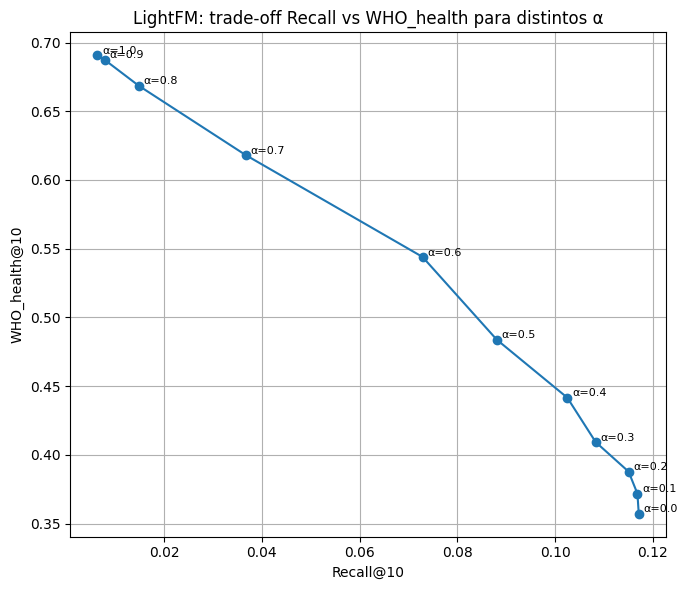

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))

plt.plot(
    df_lfm_alpha_who["Recall@k"],
    df_lfm_alpha_who["WHO_health@k"],
    marker="o"
)

for _, row in df_lfm_alpha_who.iterrows():
    plt.text(
        row["Recall@k"] + 0.001,
        row["WHO_health@k"] + 0.001,
        f"α={row['alpha']:.1f}",
        fontsize=8
    )

plt.xlabel("Recall@10")
plt.ylabel("WHO_health@10")
plt.title("LightFM: trade-off Recall vs WHO_health para distintos α")
plt.grid(True)
plt.tight_layout()
plt.show()

Notas finales:

El notebook fue corrido dentro de google collab. 
Parte del código fue implementado con asistencia de ChatGpt. Su uso especifico esta presente en esta
[conversación](https://chatgpt.com/share/6930c8e6-0af8-8005-8a79-1cd9675b114f
). (Importante notar que la pregunta de resumir entregas anteriores es para hacer que la IA contextualice el proyecto).